In [26]:
import networkx as nx
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F 
import random
from sklearn.model_selection import train_test_split
import community as community_louvain

In [3]:
# importing all following data and putting in a graph
pkl_file = open('Unfollower/15weeks_friend_dict.pkl', 'rb')
mydict2 = pickle.load(pkl_file)
pkl_file.close()

week = 0
for key, values in mydict2.items():
    if len(values[week]) == 0:
        mydict2[key] = []
        continue
    new = values[week][1]
    mydict2[key] = new

for i in mydict2.items():
    print(i)
    break
# mydict2 has format:
# user_id: [following_user_id1, following_user_id2...]

('89351626', ['1556664198', '1554031', '21837654', '596876539'])


In [4]:
# forrest fire sampling implementation and use 
def forest_fire_sampling(graph_dict, initial_burn_probability, secondary_burn_probability, max_samples=None):
    # Choose a random start node
    random.seed(947)
    start_node = random.choice(list(graph_dict.keys()))
    
    # Force starting node to have at least 100 friends 
    if len(graph_dict[start_node]) < 100:
        start_node = random.choice(list(graph_dict.keys()))
    sampled_nodes = set([start_node])
    burning_nodes = set([start_node])
    
    while burning_nodes:
        new_burning_nodes = set()
        for node in burning_nodes:
            # For each neighbor, decide if it catches fire based on the burn probability
            for neighbor in graph_dict[node]:
                if neighbor not in sampled_nodes:
                    if random.random() < (initial_burn_probability if node == start_node else secondary_burn_probability):
                        new_burning_nodes.add(neighbor)
                        sampled_nodes.add(neighbor)
                        if max_samples and len(sampled_nodes) >= max_samples:
                            return sampled_nodes
        burning_nodes = new_burning_nodes

    return sampled_nodes

# sampling has undeterministic results where sample may have few nodes or many nodes depending on whether random starting node has many or few neighbors. We may want to force the starting node to have more than 10 friends. 

sample = forest_fire_sampling(mydict2, 0.2, 0.1, max_samples=1000)
shortened_dict = defaultdict(list)
print(len(mydict2))
for k in mydict2:
    if k in sample: 
        for v in mydict2[k]:
            if v in sample: 
                shortened_dict[k].append(v)

print(len(shortened_dict))

118640
971


In [12]:
# Creating sample graph and drawing it 
subset_followers_graph = nx.DiGraph()
for k, v in shortened_dict.items():
    for neighbor in v:
        subset_followers_graph.add_edge(k, neighbor)

print(subset_followers_graph.number_of_nodes())
partition = community_louvain.best_partition(subset_followers_graph)
community_colors = {node: partition[node] for node in subset_followers_graph.nodes()}
values = [community_colors.get(node) for node in subset_followers_graph.nodes()]
print(partition)

1000


AttributeError: module 'community' has no attribute 'best_partition'

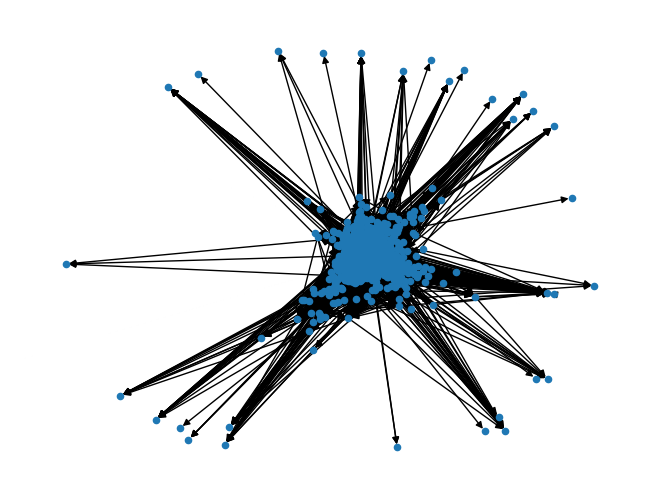

In [39]:
# Draw the graph node
nx.draw(subset_followers_graph, with_labels=False, node_size=20)

# Display the graph
plt.show()

edges before removal: 25192
edges after removal: 22673
density: 0.022695695695695697


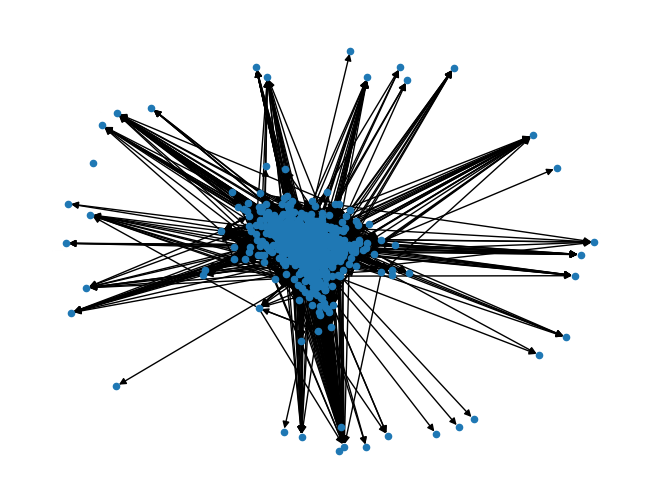

In [38]:
removed_edges_graph = subset_followers_graph.copy()
print("edges before removal:",removed_edges_graph.number_of_edges())
def remove_edges(G, k):
    # Calculate the number of edges to remove (10% of total edges)
    num_edges_to_remove = int(k * G.number_of_edges())
    
    # Get the list of all edges in the graph
    all_edges = list(G.edges())
    random.seed(947)
    # Randomly select edges to remove
    removed_edges = random.sample(all_edges, num_edges_to_remove)
    
    # Remove the selected edges from the graph
    G.remove_edges_from(removed_edges)
    
    return set(removed_edges)

removed_edges = remove_edges(removed_edges_graph,0.1)
removed_nodes_set = set()
for edge in removed_edges:
    removed_nodes_set.add(edge[0])
print("edges after removal:", removed_edges_graph.number_of_edges())
print(f"density: {nx.density(removed_edges_graph)}")

# Draw the graph node
nx.draw(removed_edges_graph, with_labels=False, node_size=20)

# Display the graph
plt.show()

In [18]:
def jaccard_prediction(G, k):
    predictions = {}
    
    # Iterate through each node in the graph
    for node1 in removed_nodes_set:
        node1_friends = set(G.neighbors(node1))
        scores = []
        
        for node2 in list(G.nodes()):
            # Skip if comparing the same node
            if node1==node2: continue
            
            # Skip if there is already an edge between the two nodes
            if G.has_edge(node1, node2): continue
            
            node2_friends = set(G.neighbors(node2))
            
            # Calculate Jaccard similarity score
            total_friends = node1_friends.union(node2_friends)
            numerator = sorted(w for w in node1_friends if w in node2_friends)
            
            if len(total_friends)==0: score=0
            else: score = len(numerator)/len(total_friends)
            
            scores.append([node2, score])
        
        predicted_links = list(filter(lambda x: x[1] > k, scores))
        if len(predicted_links)>0:
            predictions[node1] = predicted_links
    
    predicted_edges = set()
    
     # Add the predicted edges from the 'predictions' dictionary
    for node1,scores in predictions.items():
        for node2 in scores:
            predicted_edges.add((node1, node2[0]))
            
    return predicted_edges

In [19]:
def preferential_attachment_prediction(G, k):
    predictions = {}
    
     # Iterate through each node in the graph
    for node1 in removed_nodes_set:
        scores = []
        
        for node2 in list(G.nodes()):
            if node1==node2: continue
            if G.has_edge(node1, node2): continue
            
            # Calculate preferential attachment score
            score = G.degree(node1) * G.degree(node2)
            scores.append([node2, score])
        
        predicted_links = list(filter(lambda x: x[1] > k, scores))
        if len(predicted_links)>0:
            predictions[node1] = predicted_links
            
    predicted_edges = set()
    
    # Add the predicted edges from the 'predictions' dictionary
    for node1,scores in predictions.items():
        for node2 in scores:
            predicted_edges.add((node1, node2[0]))
    return predicted_edges


In [23]:
import math

# adamic adar index prediction
# input: graph, threshold k
# output: list of predicted edges
def adamic_adar_prediction(G, k):
    predictions = {}

     # Iterate through each node in the graph
    for node1 in removed_nodes_set:
        scores = []
        node1_friends =set(G.neighbors(node1))
        for node2 in list(G.nodes()):
            if node1==node2: continue
            if G.has_edge(node1, node2): continue
            node2_friends = set(G.neighbors(node2))
            common_friends = node1_friends.intersection(node2_friends)
            # Calculate score
            score = 0
            for friend in common_friends:
                friend_neighbors = len(list(G.neighbors(friend)))
                if friend_neighbors==0 or friend_neighbors==1:
                    continue
                score += 1/math.log10(friend_neighbors)
            scores.append([node2, score])

        predicted_links = list(filter(lambda x: x[1] > k, scores))
        if len(predicted_links)>0:
            predictions[node1] = predicted_links

    predicted_edges = set()

    # Add the predicted edges from the 'predictions' dictionary
    for node1,scores in predictions.items():
        for node2 in scores:
            predicted_edges.add((node1, node2[0]))
    return predicted_edges

In [14]:
def assess_accuracy(predicted_edges, actual_edges):
    actual_edge_set = set(actual_edges)
    predicted_edge_set = set(predicted_edges)
    
    # Calculate True Positive, False Positive, True Negative, False Negative
    true_positive = len(actual_edge_set.intersection(predicted_edge_set))
    false_positive = len(predicted_edge_set - actual_edge_set)
    false_negative = len(actual_edge_set - predicted_edge_set)
    
    # Calculate precision, recall, and f1 score
    
    # accuracy of positive predictions - if we predicted edge, is there actually edge?
    precision = true_positive / (true_positive + false_positive)
    
    # if there is edge, % of time we predict edge accurately?
    recall = true_positive / (true_positive + false_negative)
    
    # means of balancing
    if precision == 0 and recall == 0: f1_score = 0
    else: f1_score = 2 * (precision * recall) / (precision + recall)
    
    # Print the results
    print(f"Precision: {precision:.2f}", end=" ")
    print(f"Recall: {recall:.2f}", end = " ")
    print(f"F1 Score: {f1_score:.2f}")

In [24]:
# Jaccard prediction loop
print("Jaccard")
k = 0

while k < 1:
    jaccard_coefficient_graph_copy = removed_edges_graph.copy()
    jaccard_predicted_edges = jaccard_prediction(jaccard_coefficient_graph_copy, k)
    if len(jaccard_predicted_edges) == 0:
        break
    print(f"k={k}:")
    assess_accuracy(jaccard_predicted_edges, removed_edges)
    k += 0.1

# Preferential attachment prediction loop
print("Preferential")
k = 10000

while k < 100000:
    preferential_graph_copy = removed_edges_graph.copy()
    preferential_predicted_edges = preferential_attachment_prediction(preferential_graph_copy, k)
    if len(preferential_predicted_edges) == 0:
        break
    print(f"k={k}:")
    assess_accuracy(preferential_predicted_edges, removed_edges)
    k += 10000
    
print("Adamic-Adar")
k=5
while k < 50:
    adamic_graph_copy = removed_edges_graph.copy()
    adamic_predicted_edges = adamic_adar_prediction(adamic_graph_copy, k)
    if len(adamic_predicted_edges) == 0:
        break
    print(f"k={k}:")
    assess_accuracy(adamic_predicted_edges, removed_edges)
    k += 5

Jaccard
k=0:
Precision: 0.01 Recall: 0.90 F1 Score: 0.02
k=0.1:
Precision: 0.04 Recall: 0.42 F1 Score: 0.07
k=0.2:
Precision: 0.09 Recall: 0.15 F1 Score: 0.11
k=0.30000000000000004:
Precision: 0.21 Recall: 0.05 F1 Score: 0.07
k=0.4:
Precision: 0.42 Recall: 0.01 F1 Score: 0.01
k=0.5:
Precision: 0.67 Recall: 0.00 F1 Score: 0.00
k=0.6:
Precision: 0.67 Recall: 0.00 F1 Score: 0.00
Preferential
k=10000:
Precision: 0.02 Recall: 0.22 F1 Score: 0.04
k=20000:
Precision: 0.04 Recall: 0.05 F1 Score: 0.05
k=30000:
Precision: 0.06 Recall: 0.01 F1 Score: 0.02
k=40000:
Precision: 0.08 Recall: 0.00 F1 Score: 0.01
k=50000:
Precision: 0.17 Recall: 0.00 F1 Score: 0.00
k=60000:
Precision: 0.43 Recall: 0.00 F1 Score: 0.00
k=70000:
Precision: 0.00 Recall: 0.00 F1 Score: 0.00
Adamic-Adar
k=5:
Precision: 0.04 Recall: 0.41 F1 Score: 0.07
k=10:
Precision: 0.08 Recall: 0.17 F1 Score: 0.11
k=15:
Precision: 0.13 Recall: 0.08 F1 Score: 0.10
k=20:
Precision: 0.21 Recall: 0.04 F1 Score: 0.06
k=25:
Precision: 0.26 Reca

k=10, lr=0.01, lambda_reg=0.02
Precision: 0.00 Recall: 0.69 F1 Score: 0.01


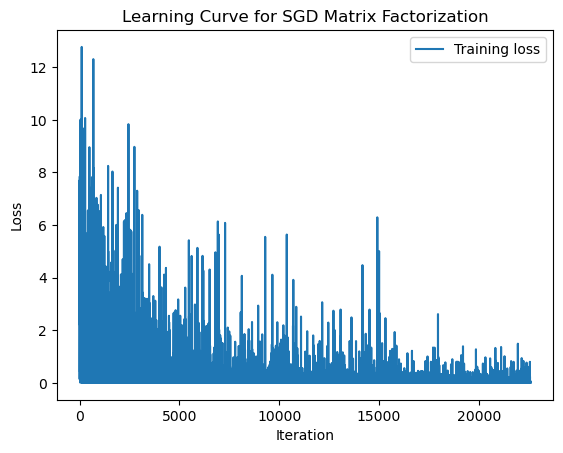

k=10, lr=0.01, lambda_reg=0.1
Precision: 0.00 Recall: 0.68 F1 Score: 0.01
k=10, lr=0.1, lambda_reg=0.02
Precision: 0.00 Recall: 0.67 F1 Score: 0.01
k=10, lr=0.1, lambda_reg=0.1
Precision: 0.00 Recall: 0.69 F1 Score: 0.01
k=100, lr=0.01, lambda_reg=0.02
Precision: 0.00 Recall: 0.66 F1 Score: 0.01
k=100, lr=0.01, lambda_reg=0.1
Precision: 0.00 Recall: 0.67 F1 Score: 0.01
k=100, lr=0.1, lambda_reg=0.02
Precision: 0.00 Recall: 0.68 F1 Score: 0.01
k=100, lr=0.1, lambda_reg=0.1
Precision: 0.00 Recall: 0.68 F1 Score: 0.01


In [25]:
# Get adjacency matrix
node_list = list(removed_edges_graph.nodes())

# Create a dictionary that maps node to index
node_to_index = {node: index for index, node in enumerate(node_list)}

A_sgd_factorize = nx.to_numpy_array(removed_edges_graph, nodelist=node_list)

def sgd_factorize(A, K, iterations=1000000, learning_rate=0.01, lambda_reg=0.02):
    """
    Factorizes the matrix A into the product of two matrices U and V using SGD.
    A: Adjacency matrix
    K: Number of latent features
    iterations: Number of iterations for SGD
    learning_rate: Learning rate for SGD updates
    lambda_reg: Regularization parameter
    """
    N, M = A.shape
    U = np.random.rand(N, K)
    V = np.random.rand(M, K)
    losses = [] 

    # SGD iterations
    for it in range(iterations):
        # Randomly select a non-zero element from A
        i, j = np.random.choice(N), np.random.choice(M)
        if A[i, j] > 0:
            # Compute prediction and error
            pred = np.dot(U[i, :], V[j, :].T)
            e = A[i, j] - pred

            # Update U and V
            U[i, :] += learning_rate * (e * V[j, :] - lambda_reg * U[i, :])
            V[j, :] += learning_rate * (e * U[i, :] - lambda_reg * V[j, :])
            
            # Compute the loss for this iteration
            loss = e**2
            losses.append(loss)
    reconstructed_A_sgd_factorize = np.dot(U, V.T)
    matrix_factorization_prediction(U, V, losses, reconstructed_A_sgd_factorize)
    
    return losses

# Assuming U and V are the factorized matrices and you've reconstructed A as reconstructed_A
threshold = 0.9 #Example threshold for determining an edge

def matrix_factorization_prediction(U, V, losses, reconstructed_A_sgd_factorize):
    sgd_factorize_predicted_edges = set()
    
    for i in range(reconstructed_A_sgd_factorize.shape[0]):
        # only give link predictions for removed nodes set
        if node_list[i] not in removed_nodes_set:
            continue
        for j in range(reconstructed_A_sgd_factorize.shape[1]):
            if i != j and reconstructed_A_sgd_factorize[i, j] >= threshold and A_sgd_factorize[i][j] != 1:   # Assuming no self-loops
                node_i = node_list[i]
                node_j = node_list[j]
                sgd_factorize_predicted_edges.add((node_i, node_j))

    assess_accuracy(sgd_factorize_predicted_edges, removed_edges)

print_graph = True
for k in [10, 100]:
    for lr in [0.01, 0.1]:
        for lambda_reg in [0.02, 0.1]:
            print(f'k={k}, lr={lr}, lambda_reg={lambda_reg}')
            losses = sgd_factorize(A_sgd_factorize, 10, learning_rate=0.1)
            if print_graph:
                plt.plot(losses, label='Training loss')
                plt.xlabel('Iteration')
                plt.ylabel('Loss')
                plt.title('Learning Curve for SGD Matrix Factorization')
                plt.legend()
                plt.show()
                print_graph = False

In [28]:
edge_list = list(subset_followers_graph.edges())
node_list = list(subset_followers_graph.nodes())
num_nodes = len(node_list)

# Create a dictionary that maps node to index
node_to_i = {node: index for index, node in enumerate(node_list)}
edges = [(node_to_i[edge[0]], node_to_i[edge[1]]) for edge in edge_list]

In [30]:
# Labels for existent edges
labels = [1] * len(edges)

# Generate non-existent edges and labels
num_fake_edges = len(edges)
fake_edges = []
fake_labels = [0] * num_fake_edges
edge_set = set(edge for edge in edges)
for _ in range(num_fake_edges):
    # Generate random nodes for fake edges
    fake_edge = (random.randint(0, num_nodes-1), random.randint(0, num_nodes-1))
    
    while fake_edge in edge_set:
        fake_edge = (random.randint(0, num_nodes-1), random.randint(0, num_nodes-1))
     
    fake_edges.append(fake_edge)
    edge_set.add(fake_edge)

all_edges = edges + fake_edges
all_labels = labels + fake_labels

In [34]:
# Change 200 to the sum of our real edges + fake edges
indices = list(range(num_fake_edges + len(edges)))
num_tot_edges = len(indices)
random_seed = 42

random.seed(random_seed)
random.shuffle(indices)

# Change 180 to be 85% of the edges
train_indices, test_indices = indices[:int(.85*num_tot_edges)], indices[int(.85*num_tot_edges):]
X_train, X_test = train_test_split(all_edges, test_size=0.1, random_state=random_seed)
y_train, y_test = train_test_split(all_labels, test_size=0.1, random_state=random_seed)

In [35]:
# GraphSage model
dgl.load_backend('pytorch')
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, hidden_size, out_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = dgl.nn.SAGEConv(in_feats, hidden_size, aggregator_type='mean')
        self.conv2 = dgl.nn.SAGEConv(hidden_size, out_feats, aggregator_type='mean')

    def forward(self, g, features):
        # First GraphSAGE layer
        x = F.relu(self.conv1(g, features))
        # Second GraphSAGE layer
        x = self.conv2(g, x)
        return x

# Edge prediction model using GraphSage 
class EdgePredictionModel(nn.Module):
    def __init__(self, in_feats, hidden_size, out_feats):
        super(EdgePredictionModel, self).__init__()
        self.sage = GraphSAGE(in_feats, hidden_size, out_feats)

    def forward(self, g, features):
        # Obtain node representations using GraphSAGE
        node_reps = self.sage(g, features)
        # Edge prediction using dot product of node representations
        src, dst = g.edges()
        src_repr = node_reps[src]
        dst_repr = node_reps[dst]
        edge_scores = torch.sum(src_repr * dst_repr, dim=1)
        return edge_scores

# Create a DGL graph from the training edge list
src_nodes_train, dst_nodes_train = zip(*X_train)
g_train = dgl.graph((src_nodes_train, dst_nodes_train))

# Define the number of input features (no input features), hidden size, and output features (binary prediction)
in_feats = 1
hidden_size = 16
out_feats = 1

# Initialize the model
model = EdgePredictionModel(in_feats, hidden_size, out_feats)

# Random initialization of node features for training and testing graphs
features_train = torch.randn(g_train.num_nodes(), in_feats)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass for training
    edge_scores_train = model(g_train, features_train)
    
    # Threshold of 0.5 to obtain binary predictions
    predictions_train = (torch.sigmoid(edge_scores_train) >= 0.5).float()
    
    labels_train = torch.tensor(y_train, dtype=torch.float32)
    
    loss_train = criterion(edge_scores_train, labels_train)
    
    loss_train.backward()
    optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss_train.item()}")

Epoch 1/10, Loss: 0.7248939275741577
Epoch 2/10, Loss: 0.7076448798179626
Epoch 3/10, Loss: 0.699104368686676
Epoch 4/10, Loss: 0.6954208612442017
Epoch 5/10, Loss: 0.6940374970436096
Epoch 6/10, Loss: 0.6936229467391968
Epoch 7/10, Loss: 0.6935721039772034
Epoch 8/10, Loss: 0.6936314702033997
Epoch 9/10, Loss: 0.6937041282653809
Epoch 10/10, Loss: 0.6937577724456787


In [36]:
# Create a DGL graph from the test edge list
src_nodes_test, dst_nodes_test = zip(*X_test)
g_test = dgl.graph((src_nodes_test, dst_nodes_test))

# Random initialization of node features for the test graph
features_test = torch.randn(g_test.num_nodes(), in_feats)

# Forward pass for testing
model.eval()
with torch.no_grad():
    edge_scores_test = model(g_test, features_test)

# Threshold of 0.5 to obtain binary predictions
predictions_test = (torch.sigmoid(edge_scores_test) >= 0.5).float()

# Calculate accuracy
correct_predictions = torch.sum(predictions_test == torch.tensor(y_test)).item()
total_samples = len(y_test)
accuracy = correct_predictions / total_samples

print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.509228021432824
